In [1]:
# Import and install libariries
# !pip install pandas numpy matplotlib seaborn scikit-learn nltk tensorflow joblib --quiet

import pandas as pd
import numpy as np
import zipfile
import re
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [2]:
# Download the NLTK Stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# import dataset
df = pd.read_csv('/cyberbullying_tweets.csv')

In [4]:
# View the data
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
# Clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", "", text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['clean_text'] = df['tweet_text'].apply(clean_text)

In [6]:
df.head()

,tweet_text,cyberbullying_type,clean_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,words katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thanks heads concerned another angry dud...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretending kurdish account like i...


In [7]:
# Encode Labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['cyberbullying_type'])
label_map = dict(zip(le.transform(le.classes_), le.classes_))

In [8]:
# Splitting dataset into test and train

X = df['clean_text']
y = df['label']
y_cat = to_categorical(y)

vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2), min_df=5)
X_vec = vectorizer.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y_cat, test_size=0.2, random_state=42, stratify=y
)


In [9]:
# Class weights for imbalanced data
y_train_single = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train_single), y=y_train_single
)
class_weights_dict = dict(enumerate(class_weights))

In [10]:
# Build model
model = Sequential([
    Dense(128, input_shape=(3000,), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

optimizer = Adam(learning_rate=1e-4)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Train model with updated Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3438 - loss: 4.5533 - val_accuracy: 0.7205 - val_loss: 2.8261
Epoch 2/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.6873 - loss: 2.8064 - val_accuracy: 0.7975 - val_loss: 2.1699
Epoch 3/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7613 - loss: 2.1687 - val_accuracy: 0.8117 - val_loss: 1.7208
Epoch 4/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7981 - loss: 1.6944 - val_accuracy: 0.8175 - val_loss: 1.3839
Epoch 5/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8129 - loss: 1.3515 - val_accuracy: 0.8205 - val_loss: 1.1396
Epoch 6/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8266 - loss: 1.0972 - val_accuracy: 0.8147 - val_loss: 0.9660
Epoch 7/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8433 - loss: 0.9138 - val_accuracy: 0.8197 - val_loss: 0.8525
Epoch 8/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8500 - loss: 0.7914 - val_

In [12]:
# Save model
model.save("cyberbullying_model.h5")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [13]:
# Evaluate Model
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")


299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8136 - loss: 0.6521

✅ Test Accuracy: 0.8134


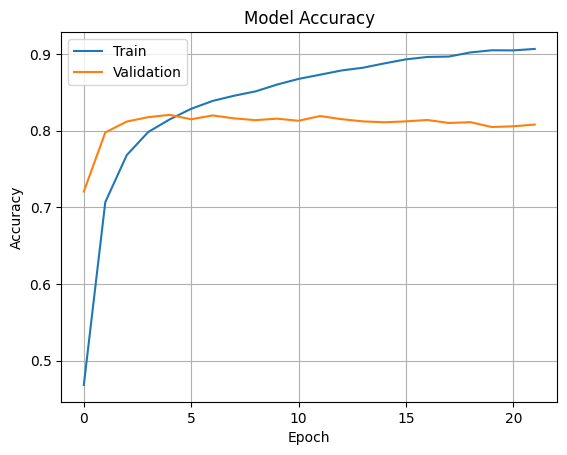

In [14]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


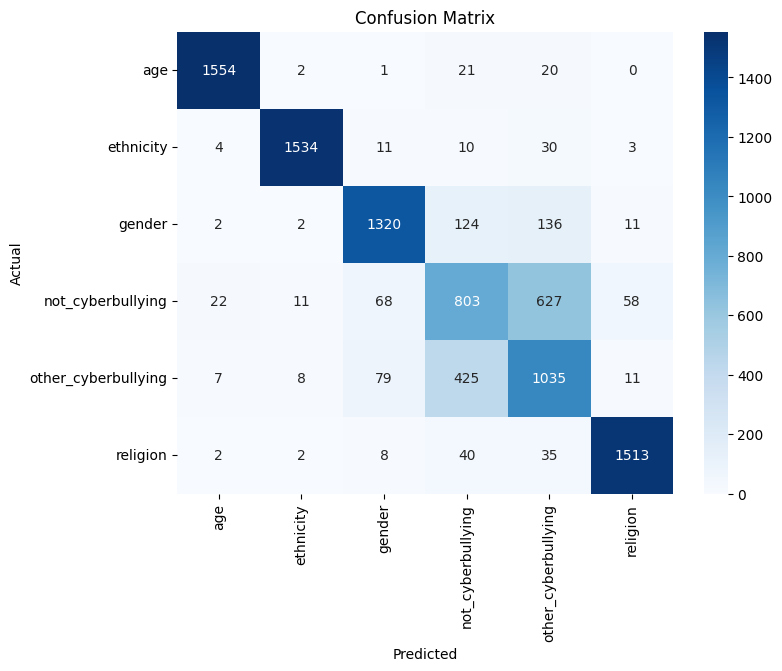


📊 Classification Report:
                     precision    recall  f1-score   support

                age       0.98      0.97      0.97      1598
          ethnicity       0.98      0.96      0.97      1592
             gender       0.89      0.83      0.86      1595
  not_cyberbullying       0.56      0.51      0.53      1589
other_cyberbullying       0.55      0.66      0.60      1565
           religion       0.95      0.95      0.95      1600

           accuracy                           0.81      9539
          macro avg       0.82      0.81      0.81      9539
       weighted avg       0.82      0.81      0.82      9539

Precision: 0.8194626884166895
Recall: 0.8133976307789076
F1 Score: 0.8151196225542879


In [15]:
# Confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))
print("Precision:", precision_score(y_true, y_pred_classes, average='weighted'))
print("Recall:", recall_score(y_true, y_pred_classes, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred_classes, average='weighted'))


In [16]:
# Live Prediction
def predict_live(text):
    cleaned = clean_text(text)
    vect = vectorizer.transform([cleaned])
    pred = model.predict(vect.toarray())
    return le.inverse_transform([np.argmax(pred)])[0]


In [17]:
# Testing the loop
print("\n🔍 LIVE PREDICTION (type 'exit' to stop):")
while True:
    user_input = input("\nEnter a tweet:\n")
    if user_input.lower() == 'exit':
        break
    prediction = predict_live(user_input)
    print("📌 Predicted Cyberbullying Type:", prediction)



🔍 LIVE PREDICTION (type 'exit' to stop):

Enter a tweet:
You are stupid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
📌 Predicted Cyberbullying Type: other_cyberbullying

Enter a tweet:
Get the fuck out
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
📌 Predicted Cyberbullying Type: other_cyberbullying

Enter a tweet:
Stupid ass bitch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
📌 Predicted Cyberbullying Type: gender

Enter a tweet:
exit
